In [ ]:
%pip install transformers matplotlib tiktoken datasets tqdm --quiet

In [ ]:
from transformers import GPT2LMHeadModel

In [ ]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2")

In [ ]:
sd_hf = model_hf.state_dict()
for k,v in sd_hf.items():
    print(k, v.shape)

In [ ]:
sd_hf['transformer.wpe.weight'].view(-1)[:20]

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(sd_hf['transformer.wpe.weight'], cmap='gray')

In [ ]:
plt.plot(sd_hf['transformer.wpe.weight'][:, 150])
plt.plot(sd_hf['transformer.wpe.weight'][:, 200])
plt.plot(sd_hf['transformer.wpe.weight'][:, 250])

In [ ]:
plt.imshow(sd_hf['transformer.h.1.attn.c_attn.weight'][:300,:300],cmap='gray')

In [ ]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2', device=0)
set_seed(42)
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5, truncation=False)

In [1]:
# tiny Shakespeare dataset
# !wget -q -O input.txt https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

Min Train Loss: 6.088532
Min Validation Loss: 6.3245
Max Hellaswag eval: 0.2451


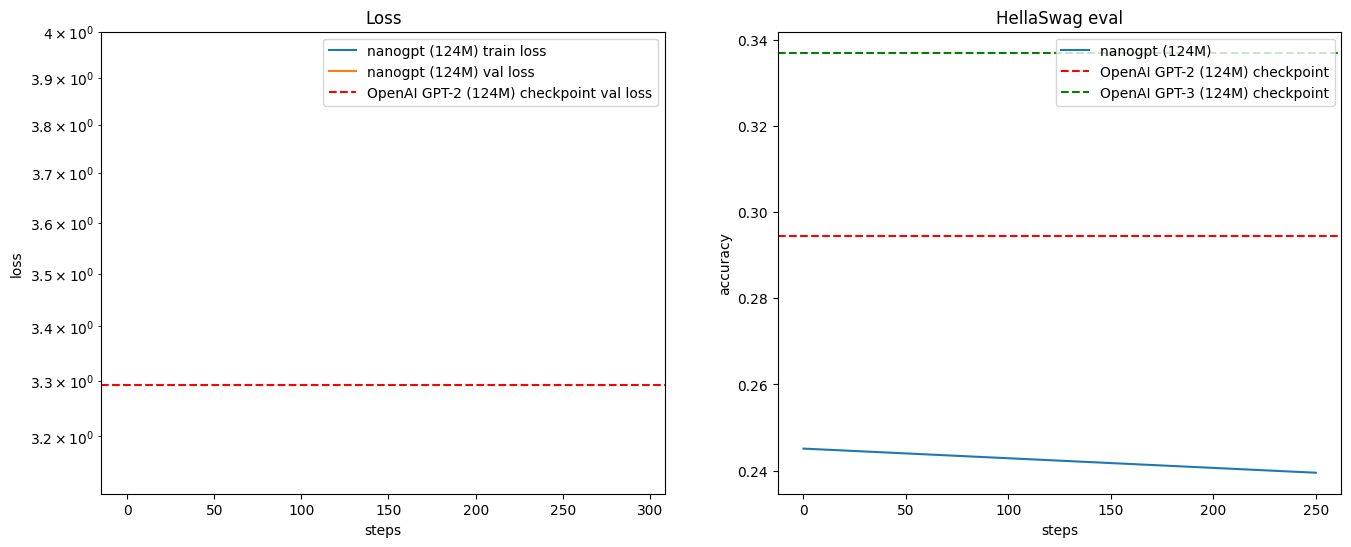

In [5]:
# parse and visualize the logfile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sz = "124M"

loss_baseline = {
    "124M": 3.2924,
}[sz]
hella2_baseline = { # HellaSwag for GPT-2
    "124M": 0.294463,
    "350M": 0.375224,
    "774M": 0.431986,
    "1558M": 0.488946,
}[sz]
hella3_baseline = { # HellaSwag for GPT-3
    "124M": 0.337,
    "350M": 0.436,
    "774M": 0.510,
    "1558M": 0.547,
}[sz]

# load the log file
with open("log/log.txt", "r") as f:
    lines = f.readlines()

# parse the individual lines, group by stream (train,val,hella)
streams = {}
for line in lines:
    step, stream, val = line.strip().split()
    if stream not in streams:
        streams[stream] = {}
    streams[stream][int(step)] = float(val)

# convert each stream from {step: val} to (steps[], vals[])
# so it's easier for plotting
streams_xy = {}
for k, v in streams.items():
    # get all (step, val) items, sort them
    xy = sorted(list(v.items()))
    # unpack the list of tuples to tuple of lists
    streams_xy[k] = list(zip(*xy))

# create figure
plt.figure(figsize=(16, 6))

# Panel 1: losses: both train and val
plt.subplot(121)
xs, ys = streams_xy["train"] # training loss
ys = np.array(ys)
plt.plot(xs, ys, label=f'nanogpt ({sz}) train loss')
print("Min Train Loss:", min(ys))
xs, ys = streams_xy["val"] # validation loss
plt.plot(xs, ys, label=f'nanogpt ({sz}) val loss')
# horizontal line at GPT-2 baseline
if loss_baseline is not None:
    plt.axhline(y=loss_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint val loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.yscale('log')
plt.ylim(top=4.0)
plt.legend()
plt.title("Loss")
print("Min Validation Loss:", min(ys))

# Panel 2: HellaSwag eval
plt.subplot(122)
xs, ys = streams_xy["hella"] # HellaSwag eval
ys = np.array(ys)
plt.plot(xs, ys, label=f"nanogpt ({sz})")
# horizontal line at GPT-2 baseline
if hella2_baseline:
    plt.axhline(y=hella2_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint")
if hella3_baseline:
    plt.axhline(y=hella3_baseline, color='g', linestyle='--', label=f"OpenAI GPT-3 ({sz}) checkpoint")
plt.xlabel("steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("HellaSwag eval")
print("Max Hellaswag eval:", max(ys))